<h1>Kaggle Home Prices</h1>
This is a machine learning project for a challenge on Kaggle to predict home prices.

In [504]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', None)

### Data Preparation and Feature Engineering:
- The training and test datasets are loaded from CSV files.
- For the MasVnrArea feature (masonry veneer area), any missing values are filled with 0, assuming that missing values mean there is no masonry veneer.
- For the LotFrontage feature (linear feet of street connected to the property), missing values are filled with the median value of LotFrontage within each neighborhood. This helps ensure that the imputed values are reasonable for the area.
- A new feature, TotalSF, is created by adding together the basement area (TotalBsmtSF), first floor area (1stFlrSF), and second floor area (2ndFlrSF). This gives the total square footage of the house.


In [507]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Impute MasVnrArea with 0
train_data['MasVnrArea'] = train_data['MasVnrArea'].fillna(0)
test_data['MasVnrArea'] = test_data['MasVnrArea'].fillna(0)

# Impute LotFrontage with median by Neighborhood
def fill_lotfrontage(df):
    df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median())
    )
    return df

train_data = fill_lotfrontage(train_data)
test_data = fill_lotfrontage(test_data)

# Add TotalSF feature
train_data['TotalSF'] = train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF']
test_data['TotalSF'] = test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF']

### Exploratory Data Analysis: SalePrice Statistics
- This section calculates and displays basic statistics for the SalePrice column in the training data, including count, mean, standard deviation, minimum, maximum, and quartiles.
- It also prints the median, standard deviation, skewness (a measure of asymmetry), and kurtosis (a measure of how heavy the tails are) for the sale prices.
- Finally, a histogram is plotted to visualize the distribution of house sale prices, helping to identify the overall range, central tendency, and any skewness in the data.

SalePrice statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Median SalePrice: 163000.0
Standard Deviation: 79442.50288288663
Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


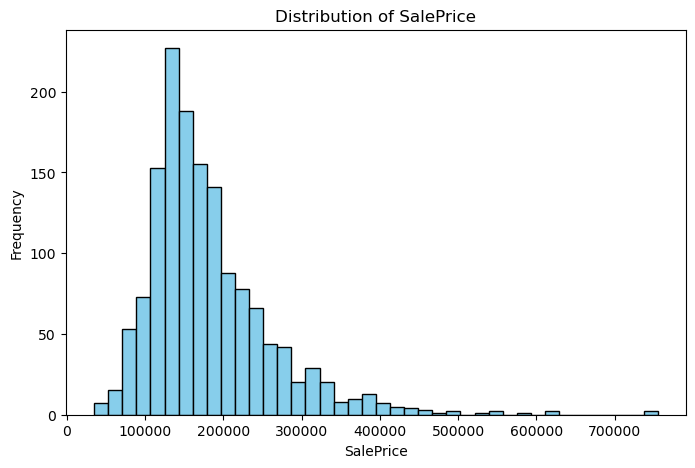

In [510]:
# Basic statistics for SalePrice
print("SalePrice statistics:")
print(train_data['SalePrice'].describe())

mean_price = train_data['SalePrice'].mean()
std_price = train_data['SalePrice'].std()

# Additional statistics
print("\nMedian SalePrice:", train_data['SalePrice'].median())
print("Standard Deviation:", train_data['SalePrice'].std())
print("Skewness:", train_data['SalePrice'].skew())
print("Kurtosis:", train_data['SalePrice'].kurt())

# Optional: Visualize the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.hist(train_data['SalePrice'], bins=40, color='skyblue', edgecolor='black')
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('Distribution of SalePrice')
plt.show()

### Preprocessing Setup

In [516]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

### Model Training and Validation All Features
- Trains a Random Forest model using all relevant features (excluding the target, ID, and redundant floor area columns).
- Splits the data into training and validation sets, preprocesses numerical and categorical features, and fits the model.
- Calculates and prints the validation MAE and RMSE to measure prediction accuracy.
- Also reports the MAE as a fraction of the standard deviation and as a percentage of the mean sale price, to put the error in context with the data’s spread and average value.

In [519]:
# Exclude target, Id, and redundant floor area features
all_features = train_data.columns.drop([
    'SalePrice', 'Id', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF'
])
X_all = train_data[all_features]
X_test_all = test_data[all_features]

X_train_all, X_valid_all, y_train_all, y_valid_all = train_test_split(X_all, y, train_size=0.8, random_state=0)

clf_all = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('num', SimpleImputer(strategy='mean'), X_all.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), X_all.select_dtypes(include=['object']).columns)
    ])),
    ('model', RandomForestRegressor(n_estimators=100, random_state=0))
])
clf_all.fit(X_train_all, y_train_all)
val_preds_all = clf_all.predict(X_valid_all)
mae_all = mean_absolute_error(y_valid_all, val_preds_all)
rmse_all = root_mean_squared_error(y_valid_all, val_preds_all)
print(f"All Features - Validation MAE: {mae_all:.2f}")
print(f"All Features - Validation RMSE: {rmse_all:.2f}")

# Assuming you have already calculated 'mae' after model prediction
mae_ratio = mae / std_price
mae_pct_mean = 100 * mae / mean_price
print(f"MAE / Std Dev: {mae_ratio:.3f}")
print(f"MAE as % of Mean SalePrice: {mae_pct_mean:.2f}%")

All Features - Validation MAE: 16882.37
All Features - Validation RMSE: 33136.65
MAE / Std Dev: 0.222
MAE as % of Mean SalePrice: 9.75%


### Actual vs. Predicted Scatterplot

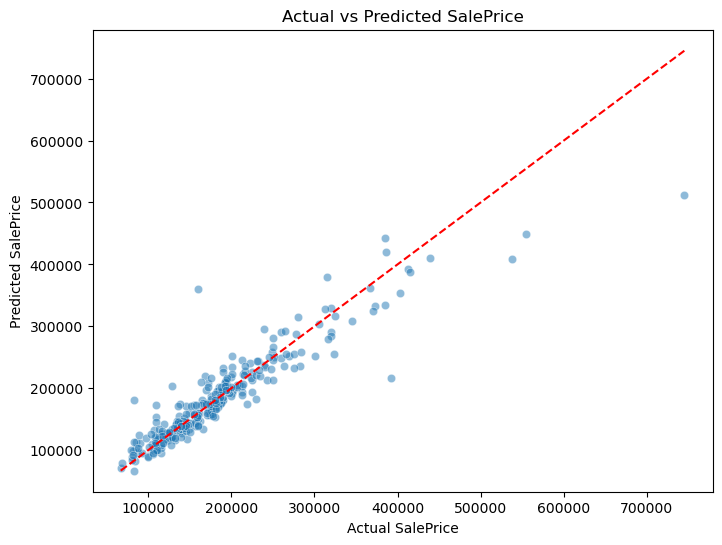

In [522]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_valid, y=val_preds, alpha=0.5)
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  # Diagonal line
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice')
plt.show()

In [486]:
final_preds = clf.predict(X_test)
output = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': final_preds})
output.to_csv('submission.csv', index=False)